# __ASSIGNMENT 5__

## __IMPORT LIBRARIES__

In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


## __1.__

In [543]:
data = pd.read_csv('height_weight_genders.csv')
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [544]:
def replace_gender(g):
    if g == "Male": 
        return 0
    else:
        return 1

data["Gender"] = data["Gender"].apply(replace_gender) 
data.head()
        

,Gender,Height,Weight
0,0,73.847017,241.893563
1,0,68.781904,162.310473
2,0,74.110105,212.740856
3,0,71.730978,220.042470
4,0,69.881796,206.349801


In [545]:
data = np.array([data["Gender"],data["Height"], data["Weight"]]).T

In [546]:
print(data.shape)

(10000, 3)


## __2.__

In [547]:
# NOTE: use vectorized operationsssss !!!!!!
h = data[:, 1]

mn = np.mean(h)
std_dev = np.std(h)

data[:, 1] = (data[:, 1] - mn) / std_dev

print(data[:, 1])

[ 1.94406149  0.62753668  2.01244346 ... -0.64968792  0.69312469
 -1.14970831]


## __3.__

Z is a matrix where forst columns are 1's and second ones are height normalized values 

In [548]:
# NOTE: reshape turn the vecto into a column vector!!
# NOTE: horizontally stacks them 
Z = np.hstack([np.ones((data.shape[0], 1)), data[:, 1].reshape(-1, 1)])
Y = data[:, 2].reshape(-1,1)
print(Z.shape)
print(Y.shape)
print(Z)
print(Y)

(10000, 2)
(10000, 1)
[[ 1.          1.94406149]
 [ 1.          0.62753668]
 [ 1.          2.01244346]
 ...
 [ 1.         -0.64968792]
 [ 1.          0.69312469]
 [ 1.         -1.14970831]]
[[241.89356318]
 [162.31047252]
 [212.74085556]
 ...
 [128.47531878]
 [163.85246135]
 [113.64910268]]


## __4.__

In [549]:
# NOTE: MEAN SQUARED ERROR 
def objective(y,Z,x):
    N = Z.shape[0]
    return (1/(2*N))*((np.linalg.norm(y- (Z @ x)))**2)

## __5.__

In [550]:
def gradient(y,Z,x):
    N = Z.shape[0]
    return (1/N) * (Z.T @ ((Z @ x) - y)) 

## __6.__

In [551]:
def hessian(Z):
    N = Z.shape[0]
    return 1/N * (Z.T @ Z)

In [552]:
def check_u_strongly(Z):
    eigh,_ = np.linalg.eigh(hessian(Z))
    # NOTE: u is the smallest eigenvalue
    u = np.min(eigh)
    return u

print(f'f is µ-strongly convex and with µ {check_u_strongly(Z)} ')

f is µ-strongly convex and with µ 0.9999999999999997 


## __7.__

In [553]:
def compute_global_minimiser(Z,y):
    # NOTE: solve works like the equal in between the two
    # NOTE: remember we are solvin Ax = b so linalg solve search for x, in our case x*
    return np.linalg.solve(Z.T @ Z, Z.T @ y)

x_star = compute_global_minimiser(Z,Y)
optimal = objective(Y,Z, x_star)
print(f'the optimal value of the objective f (x*) is : {optimal} with x*={x_star}')

the optimal value of the objective f (x*) is : 74.6467419745648 with x*=[[161.44035683]
 [ 29.69099655]]


## __8.__

In [554]:
# NOTE: Stochastic gradient estimate is the gradient of a single point i(0)

def compute_stochastic_gradient_estimate(x0,Z,y):
    i0 = np.random.randint(0, Z.shape[0]) 
    Zi = Z[i0].reshape(1,-1)
    yi = y[i0]
    g0 = Zi.T @ (Zi @ x0 - yi)
    return g0

x0 = np.array([10,2]).reshape(-1,1)
g0 = compute_stochastic_gradient_estimate(x0,Z,Y)
print(f'The stochastic gradient estimate is : {g0}')

The stochastic gradient estimate is : [[-135.84424184]
 [  67.48357504]]


## __9.__

In [555]:
def real_grad(Z,y,x0):
    holder = 0
    for i in range(Z.shape[0]):
        holder += (Z[i].T * (Z[i] @ x0 - y[i]))
    avg = holder / Z.shape[0]
    return avg

print(f'The real gradient is : {real_grad(Z,Y,x0)}')

The real gradient is : [-151.44035683  -27.69099655]


In [556]:
def empirical_check(times,Z,y,real_g0,x0):
    holder = 0
    for _ in range(times):
        holder += compute_stochastic_gradient_estimate(x0,Z,y)
    avg = holder / times
    return avg

avg = empirical_check(10000,Z,Y,g0,x0)
print(f'The average obtained estimates is : {avg} for 10000 iters')

avg_2 = empirical_check(15000,Z,Y,g0,x0)
print(f'The average obtained estimates is : {avg_2} for 15000 iters')

The average obtained estimates is : [[-150.94407188]
 [ -26.89840534]] for 10000 iters
The average obtained estimates is : [[-151.49329062]
 [ -28.31310228]] for 15000 iters


It is definetly possible to see that the average is close to ∇fi(0) (x(0) ) and by doing more iterations the error decreases

## __10.__

In [557]:
def stochastic_gradient(y,Z,x,m):
    # NOTE: this samples a quantity m of random indices from the dataset
    idx = np.random.choice(Z.shape[0], m, replace=False)
    grad_est = 0
    for i in idx:
        grad_est += Z[i].reshape(-1,1) @ (Z[i].reshape(-1,1).T @ x - y[i]) 
    grad_est /= m
    return grad_est 

## __11.__

In [558]:
def gradient_descent(Z,y,x0,alpha=0.1,tol=1e-4,max_iters=10000):
    start_time = time.time()
    x = x0.astype(np.float64)
    iter = 0
    saved_values = []
    optimality_error = []
    for k in range(max_iters):

        obj = objective(y,Z,x)
        grad = gradient(y,Z,x)
        opt_err = obj - optimal

        # NOTE: appending to keep track
        optimality_error.append(opt_err)
        saved_values.append(obj)

        norm_grad = np.linalg.norm(grad)
        iter += 1
        # NOTE : check if slope is almost flat
        if norm_grad < tol:
            print(f'final optimality error is {opt_err} at iter {iter} with a running time of {time.time() - start_time}')
            break
        
        x -= alpha * grad

    return x,saved_values,optimality_error,iter

x,saved_values,optimality_error,iterations = gradient_descent(Z,Y,x0)

final optimality error is 4.243261741976312e-09 at iter 137 with a running time of 0.04032611846923828


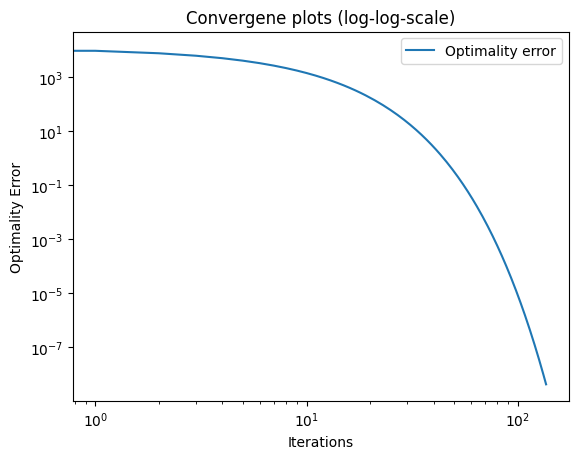

In [559]:
plt.plot(optimality_error, label="Optimality error")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Optimality Error')
plt.title('Convergene plots (log-log-scale)')
plt.legend()
plt.show()

## __12.__

In [560]:
def stochastic_gradient_descent(Z, y, x0, m, alpha=0.1, tol=1e-4, max_iters=10000):
    start_time = time.time()
    x = x0.astype(np.float64)
    saved_values = []
    optimality_error = []
    for k in range(max_iters):

        # NOTE: main difference is here where we perform gradient using the mini-batch
        # The random choice is made directly in the stochastic grad function (random sampling)
        grad = stochastic_gradient(y,Z,x,m)
        
        obj = objective(y, Z, x)

        opt_err = obj - optimal
        optimality_error.append(opt_err)
        saved_values.append(obj)

        x -= alpha * grad.reshape(-1,1)

        if np.linalg.norm(grad) < tol:
            break
    
    print(f'final optimality error is {optimality_error[-1]} at iter {k+1} with a running time of {time.time() - start_time}')
    return x,saved_values,optimality_error,k+1

## __13.__

In [561]:
m = 1
x_stc,saved_values_stc,optimality_error_stc,iterations_stc=stochastic_gradient_descent(Z,Y,x0,m)

final optimality error is 2.526034402739299 at iter 10000 with a running time of 4.189175367355347


## __14.__

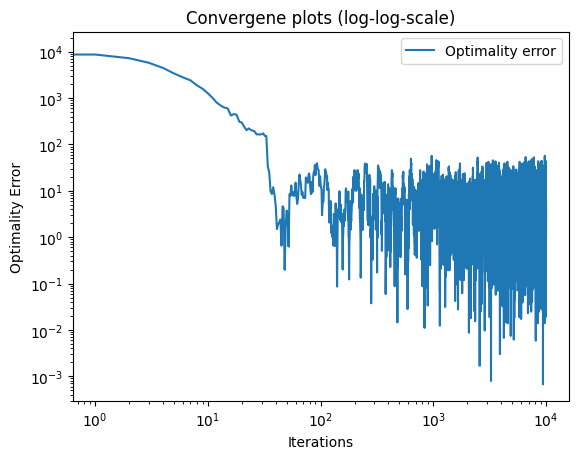

In [562]:
plt.plot(optimality_error_stc, label="Optimality error")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Optimality Error')
plt.title('Convergene plots (log-log-scale)')
plt.legend()
plt.show()

This creates a lot of noise, fluctuation is really spreaded and this is due to the very small m which makes the estimate based only on 1 random sample which is not very good nor precise. This leads to a very slow and bad convergence.

## __15.__

In [563]:
new_m = 10
x_stc_10,saved_values_stc_10,optimality_error_stc_10,iterations_stc_10=stochastic_gradient_descent(Z,Y,x0,new_m)

final optimality error is 0.8074906257592005 at iter 10000 with a running time of 4.270625352859497


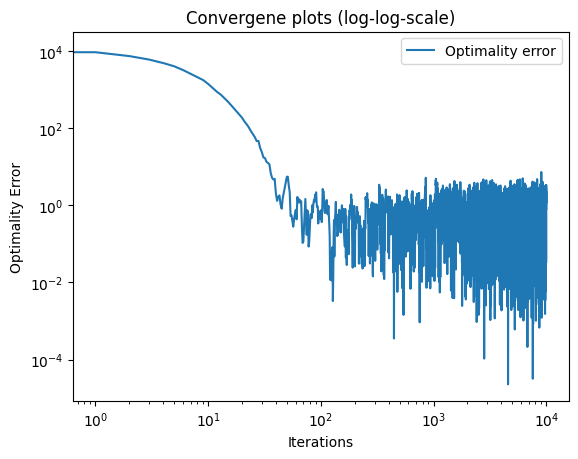

In [564]:
plt.plot(optimality_error_stc_10, label="Optimality error")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Optimality Error')
plt.title('Convergene plots (log-log-scale)')
plt.legend()
plt.show()

In this case from the plot we evince that there is still noise but update is a bit better, this is due to the fact that now the batch is bigger making the estimate based not only on 1 random sample but on 10, this makes it more precise, reducing fluctuation a bit. Still fluctuation is there because we are always talking about approximations!

## __16.__

In [565]:
def better_stochastic_gradient_descent(Z, y, x0, m, alpha=0.1, tol=1e-4, max_iters=10000):
    start_time = time.time()
    x = x0.astype(np.float64)
    saved_values = []
    optimality_error = []
    for k in range(max_iters):
        
        # NOTE: main difference is here where we perform gradient using the mini-batch
        # The random choice is made directly in the stochastic grad function (random sampling)
        grad = stochastic_gradient(y,Z,x,m)
        
        obj = objective(y, Z, x)

        opt_err = obj - optimal
        optimality_error.append(opt_err)
        saved_values.append(obj)

        alpha = 1/(k+1)
        x -= alpha * grad.reshape(-1,1)

        if np.linalg.norm(grad) < tol:
            break
    
    print(f'final optimality error is {optimality_error[-1]} at iter {k+1} with a running time of {time.time() - start_time}')
    return x,saved_values,optimality_error,k+1

## __17.__

In [566]:
better_x_stc_10,better_saved_values_stc_10,better_optimality_error_stc_10,better_iterations_stc_10=better_stochastic_gradient_descent(Z,Y,x0,new_m)

final optimality error is 0.0003350249671996153 at iter 10000 with a running time of 5.938428640365601


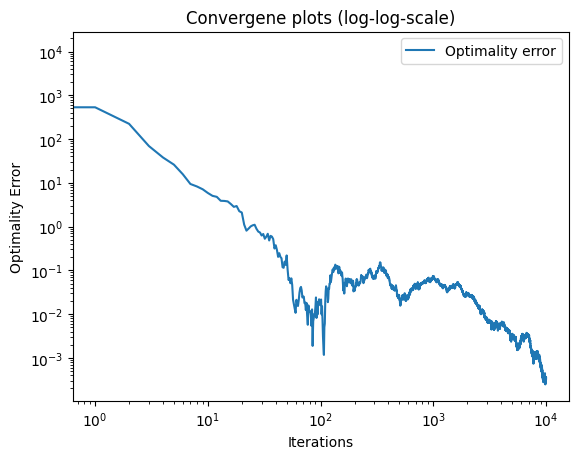

In [567]:
plt.plot(better_optimality_error_stc_10, label="Optimality error")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Optimality Error')
plt.title('Convergene plots (log-log-scale)')
plt.legend()
plt.show()

In this case the fact that we adapt the step size tends to make the optimiziation perform better because as we get closer to the optimal, the step size moves more carefully and doesn't do big jumps as before

## __18.__

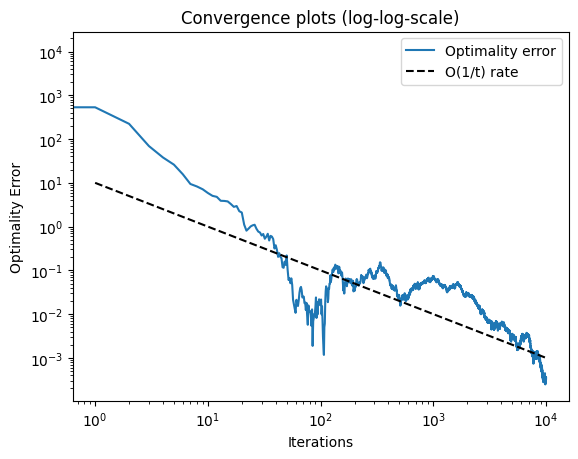

In [568]:

plt.plot(better_optimality_error_stc_10, label="Optimality error")
k_vals = np.arange(1, better_iterations_stc_10+1)
theoretical_line = 10 / k_vals
plt.plot(k_vals, theoretical_line, 'k--', label='O(1/t) rate')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Optimality Error')
plt.title('Convergence plots (log-log-scale)')
plt.legend()
plt.show()

